In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 15 12:37:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   35C    P8    16W / 100W |     46MiB /  6144MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv


2024-06-15 12:37:25.403859: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 12:37:25.416417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 12:37:25.562117: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-15 12:37:25.562630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 12:37:26.382277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=90

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=50000
LEARNING_RATE=0.001

# Gym CartPole-v1

Un péndulo está unido mediante una articulación no accionada a un carro que se desplaza a lo largo de una pista sin fricción. El péndulo se coloca verticalmente sobre el carro y el objetivo es equilibrar el poste aplicando fuerzas en dirección izquierda y derecha sobre el carro.

**Espacio de Acciones**: Espacio discreto de tamaño (2)

* Acción 0: Empujar el carro hacia la izquierda
* Acción 1: Empujar el carro hacia la derecha

**Espacio de Observaciones**: Espacio continuuo de tamaño (4,)

* La observación es un ndarray con forma (4,) con los valores correspondientes a las siguientes posiciones y velocidades:
    * Num     |     Observación |     Min |    Max

    * 0    Posición del Carro                 - 4.8                            4.8

    *  1    Velocidad del Carro                 -Inf                            Inf

    * 2    Ángulo del Poste              ~ -0.418 rad (-24°)          ~ 0.418 rad (24°)

    * 3    Velocidad Angular del Poste         -Inf                            Inf





In [6]:
# Definimos el entorno
env= gym.make('CartPole-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

2
4


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a,s',r] reales o sintéticas, de longitud 2*ob_space.shape[0] + ac_space.n+1.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=4,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=4,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=4, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 4)           48        
                                                                 
 layer2 (Dense)              (None, None, 4)           20        
                                                                 
 layer3 (Dense)              (None, None, 4)           20        
                                                                 
 prob (Dense)                (None, None, 1)           5         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-15 12:37:29.368342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-15 12:37:29.368367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-15 12:37:29.368370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-15 12:37:29.368453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-06-15 12:37:29.368465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-06-15 12:37:29.368467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss


## Clase del Discriminador

In [9]:
#########################################################################################
# Clase DISCRIMINADOR
########################################################################################
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, expert_s_prima, expert_r, agent_s, agent_a, agent_s_prima, agent_r):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net

        # -Experto: [s,a,s',r]
        self.expert_s=expert_s
        self.expert_a=expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)


        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)
        expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, expert_r], axis=1)

        # -Agente:  [s,a,s',r]
        self.agent_s=agent_s
        self.agent_a=agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)

        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a_s_r)

        #-Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 4, s=[s1,s2,s3,s4]
# Output: acciones, listas de tamaño 2, a=[a1,a2]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=4, activation=tf.tanh,name='layer1'),
        layers.Dense(units=4, activation=tf.tanh, name='layer2'),
        layers.Dense(units=2, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 4)           20        
                                                                 
 layer2 (Dense)              (None, None, 4)           20        
                                                                 
 layer3 (Dense)              (None, None, 2)           10        
                                                                 
 layer4 (Dense)              (None, None, 2)           6         
                                                                 
Total params: 56 (224.00 Byte)
Trainable params: 56 (224.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=4, activation=tf.tanh,name='layer1'),
            layers.Dense(units=4, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()



Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 4)           20        
                                                                 
 layer2 (Dense)              (None, None, 4)           20        
                                                                 
 layer3 (Dense)              (None, None, 1)           5         
                                                                 
Total params: 45 (180.00 Byte)
Trainable params: 45 (180.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env=env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    # Devuelve los parámetros \theta de la política \pi
    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] sinteticos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0


        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0


            # La primera acción de cada episodio se crea con la red neuronal
            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            truncated=False
            terminated=False

            # Tenemos una política entrenada
            Policy = Policy_net('policy',env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estaactiondo
                # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
                observations.append(next_obs)  # S_i-1

                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True or truncated==True:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs



        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        next_observations = np.reshape(next_observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)
        
        # Devolvemos la secuencia (S,A,S',R) junto con la política anterior y la actual política,
        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes



# Extended GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen1=np.concatenate([generate_observations,generate_a_one_hot],axis=1)

        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)

        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('CartPole-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):

        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]


        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot,generate_observations.shape)
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        if generate_next_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        else:
           generate_next_observations_new= np.resize(generate_next_observations, generate_observations.shape)
           dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations_new], axis=1)

        rewards=np.array(rewards).reshape(-1,1)

        
        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)
        
        
        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento 
        #if len(dataset_gen) >= BATCH_SIZE: 
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices[0]]
    
    
        # 3) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento y las combinamos
        dataset_gen=dataset_gen.reshape(1,-1)
        combined_images = tf.concat([X_train, dataset_gen], axis=0)


        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat( [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0 )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )



        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations) #       generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

        
        
        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())



        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}



# Experimentación de GAIL con CartPole

## Experimento 1

### Construcción de base de datos experta con 1 trayectoria 

In [16]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

500


In [18]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [19]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [20]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 400
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 100


In [21]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [24]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)



/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(





d_loss= 2.5417097

g_loss= -0.923686
1/5 [=====>........................] - ETA: 29:45 - d_loss: 2.5417 - g_loss: -0.9237


d_loss= 2.5498085

g_loss= -0.71743166
2/5 [===========>..................] - ETA: 22:47 - d_loss: 2.5458 - g_loss: -0.8206


d_loss= 2.5695267

g_loss= -0.7050891
3/5 [=================>............] - ETA: 15:00 - d_loss: 2.5537 - g_loss: -0.7821


d_loss= 2.527727

g_loss= -0.8899074
4/5 [=======================>......] - ETA: 7:30 - d_loss: 2.5472 - g_loss: -0.8090 


d_loss= 2.545199

g_loss= -1.34268
5/5 [==============================] - 2237s 448s/step - d_loss: 2.5468 - g_loss: -0.9158


### Evaluación de GAIL

In [25]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.6234 - accuracy: 0.0022
>Loss real: 
0.6366761922836304
>Loss fake: 
0.6233932971954346


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

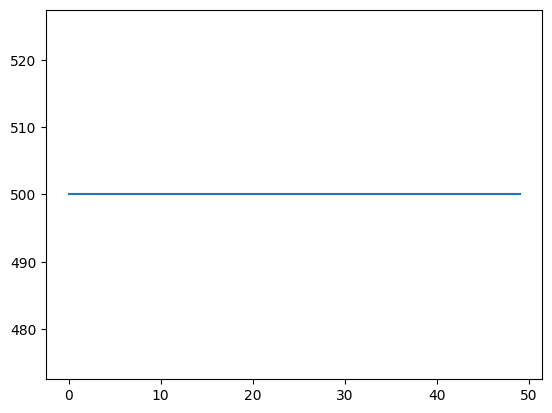


Recompensa de Media: 500.0 



In [26]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

### Construcción de base de datos experta con 2 trayectoria 

In [27]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)



print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [28]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1000


In [29]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [30]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [31]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 800
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 200


In [32]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [33]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [34]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [35]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.5328155

g_loss= -0.99532294
1/9 [==>...........................] - ETA: 59:57 - d_loss: 2.5328 - g_loss: -0.9953


d_loss= 2.5276651

g_loss= -0.7143962
2/9 [=====>........................] - ETA: 53:18 - d_loss: 2.5302 - g_loss: -0.8549


d_loss= 2.5338128

g_loss= -0.74782234
3/9 [=========>....................] - ETA: 44:50 - d_loss: 2.5314 - g_loss: -0.8192


d_loss= 2.4787378

g_loss= -1.2698044
4/9 [============>.................] - ETA: 37:05 - d_loss: 2.5183 - g_loss: -0.9318


d_loss= 2.5274987

g_loss= -1.0412686
5/9 [===============>..............] - ETA: 29:33 - d_loss: 2.5201 - g_loss: -0.9537


d_loss= 2.5560112

g_loss= -1.5757942
6/9 [===================>..........] - ETA: 22:09 - d_loss: 2.5261 - g_loss: -1.0574


d_loss= 2.474061

g_loss= -0.47336268
7/9 [======================>.......] - ETA: 14:47 - d_loss: 2.5187 - g_loss: -0.9740


d_loss= 2.4994695

g_loss= -0.4302683
8/9 [=========================>....] - ETA: 7:23 - d_loss: 2.5163 - g_loss: -0.906

### Evaluación de GAIL

In [36]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.6110 - accuracy: 0.0000e+00
>Loss real: 
0.6140761375427246
>Loss fake: 
0.61102294921875


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

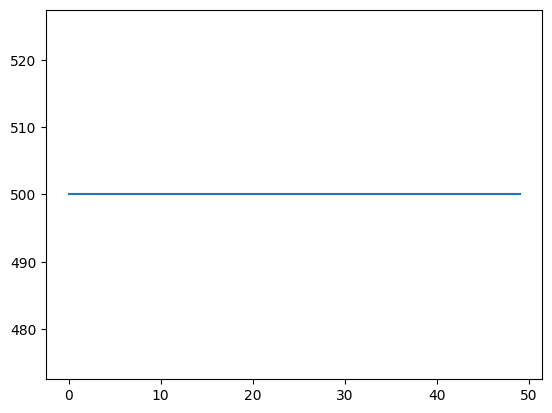


Recompensa de Media: 500.0 



In [37]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

### Construcción de base de datos experta con 1 trayectoria 

In [38]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [39]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1500


In [40]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [41]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [42]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1200
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 300


In [43]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [44]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [45]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [46]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.508256

g_loss= -1.0001738
 1/14 [=>............................] - ETA: 1:33:05 - d_loss: 2.5083 - g_loss: -1.0002


d_loss= 2.5618472

g_loss= -0.60384005
 2/14 [===>..........................] - ETA: 1:27:23 - d_loss: 2.5351 - g_loss: -0.8020


d_loss= 2.543202

g_loss= -0.5255664
 3/14 [=====>........................] - ETA: 1:19:16 - d_loss: 2.5378 - g_loss: -0.7099


d_loss= 2.4777832

g_loss= -0.53420806
 4/14 [=======>......................] - ETA: 1:12:39 - d_loss: 2.5228 - g_loss: -0.6659


d_loss= 2.5061386

g_loss= -0.8661372
 5/14 [=========>....................] - ETA: 1:05:28 - d_loss: 2.5194 - g_loss: -0.7060


d_loss= 2.5075858

g_loss= -1.5282884
 6/14 [===========>..................] - ETA: 58:05 - d_loss: 2.5175 - g_loss: -0.8430  


d_loss= 2.508922

g_loss= -0.15607238
 7/14 [==============>...............] - ETA: 50:47 - d_loss: 2.5162 - g_loss: -0.7449


d_loss= 2.502104

g_loss= -1.0714557
 8/14 [================>.............] - ETA: 43:35 - d_los

### Evaluación de GAIL

In [47]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.4905 - accuracy: 0.0000e+00
>Loss real: 
0.5812050700187683
>Loss fake: 
0.49050667881965637


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

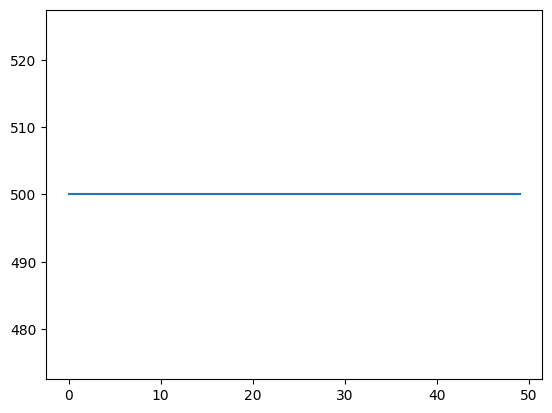


Recompensa de Media: 500.0 



In [48]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

### Construcción de base de datos experta con 4 trayectoria 

In [49]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [50]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2000


In [51]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [52]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [53]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1600
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 400


In [54]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [55]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [56]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [57]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.4652963

g_loss= -1.6609634
 1/18 [>.............................] - ETA: 2:01:54 - d_loss: 2.4653 - g_loss: -1.6610


d_loss= 2.466508

g_loss= -0.70675635
 2/18 [==>...........................] - ETA: 1:56:51 - d_loss: 2.4659 - g_loss: -1.1839


d_loss= 2.433167

g_loss= -0.995834
 3/18 [====>.........................] - ETA: 1:49:03 - d_loss: 2.4550 - g_loss: -1.1212


d_loss= 2.4485803

g_loss= -0.6981693
 4/18 [=====>........................] - ETA: 1:41:41 - d_loss: 2.4534 - g_loss: -1.0154


d_loss= 2.5028334

g_loss= -1.6127505
 5/18 [=======>......................] - ETA: 1:34:13 - d_loss: 2.4633 - g_loss: -1.1349


d_loss= 2.402663

g_loss= -0.7419017
 6/18 [=========>....................] - ETA: 1:26:51 - d_loss: 2.4532 - g_loss: -1.0694


d_loss= 2.4733095

g_loss= -1.1649255
 7/18 [==========>...................] - ETA: 1:19:52 - d_loss: 2.4561 - g_loss: -1.0830


d_loss= 2.4399676

g_loss= -0.8824468
 8/18 [============>.................] - ETA: 1:12:29 - d_l

### Evaluación de GAIL

In [58]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.5122 - accuracy: 0.0000e+00
>Loss real: 
0.5317344069480896
>Loss fake: 
0.5121617913246155


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

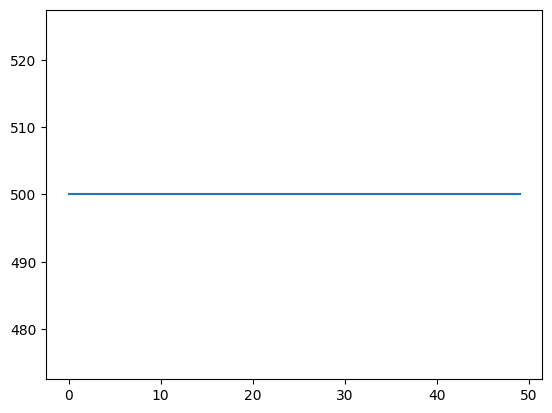


Recompensa de Media: 500.0 



In [59]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

### Construcción de base de datos experta con 5 trayectoria 

In [60]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [61]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

2500


In [62]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [63]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [64]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2000
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 500


In [65]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [66]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [67]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [68]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.4451404

g_loss= -0.46894056
 1/23 [>.............................] - ETA: 2:39:01 - d_loss: 2.4451 - g_loss: -0.4689


d_loss= 2.4088318

g_loss= -1.4385024
 2/23 [=>............................] - ETA: 2:29:04 - d_loss: 2.4270 - g_loss: -0.9537


d_loss= 2.4522262

g_loss= -0.4545961
 3/23 [==>...........................] - ETA: 2:24:15 - d_loss: 2.4354 - g_loss: -0.7873


d_loss= 2.4112628

g_loss= -0.4263614
 4/23 [====>.........................] - ETA: 2:16:49 - d_loss: 2.4294 - g_loss: -0.6971


d_loss= 2.4202702

g_loss= -0.5941934
 5/23 [=====>........................] - ETA: 2:09:42 - d_loss: 2.4275 - g_loss: -0.6765


d_loss= 2.4055822

g_loss= -0.8841197
 6/23 [======>.......................] - ETA: 2:02:22 - d_loss: 2.4239 - g_loss: -0.7111


d_loss= 2.4199872

g_loss= -0.6483916
 7/23 [========>.....................] - ETA: 1:55:43 - d_loss: 2.4233 - g_loss: -0.7022


d_loss= 2.4243279

g_loss= -0.7948768
 8/23 [=========>....................] - ETA: 1:48:56 -

### Evaluación de GAIL

In [69]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.4607 - accuracy: 0.0000e+00
>Loss real: 
0.46651142835617065
>Loss fake: 
0.4606764316558838


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

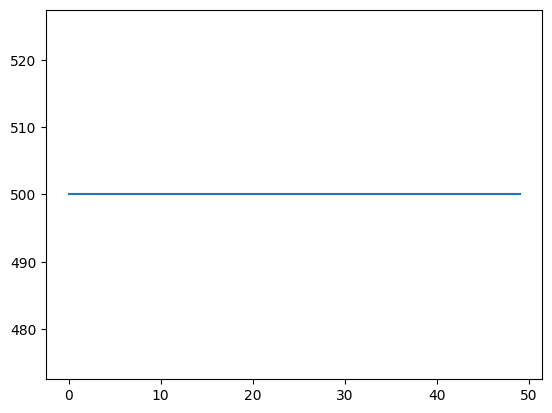


Recompensa de Media: 500.0 



In [70]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

### Construcción de base de datos experta con 1 trayectoria 

In [71]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [72]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

3000


In [73]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [74]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [75]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2400
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 600


In [76]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [77]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [78]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [79]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.3719418

g_loss= -1.294208
 1/27 [>.............................] - ETA: 3:06:26 - d_loss: 2.3719 - g_loss: -1.2942


d_loss= 2.3445318

g_loss= -0.3907235
 2/27 [=>............................] - ETA: 3:00:36 - d_loss: 2.3582 - g_loss: -0.8425


d_loss= 2.4356823

g_loss= -0.44539598
 3/27 [==>...........................] - ETA: 2:52:57 - d_loss: 2.3841 - g_loss: -0.7101


d_loss= 2.3197966

g_loss= -1.4367797
 4/27 [===>..........................] - ETA: 2:45:33 - d_loss: 2.3680 - g_loss: -0.8918


d_loss= 2.3597517

g_loss= -1.3791081
 5/27 [====>.........................] - ETA: 2:38:41 - d_loss: 2.3663 - g_loss: -0.9892


d_loss= 2.359806

g_loss= -0.95503277
 6/27 [=====>........................] - ETA: 2:34:15 - d_loss: 2.3653 - g_loss: -0.9835


d_loss= 2.3376777

g_loss= -0.67699385
 7/27 [======>.......................] - ETA: 2:26:36 - d_loss: 2.3613 - g_loss: -0.9397


d_loss= 2.345596

g_loss= -0.68493694
 8/27 [=======>......................] - ETA: 2:19:22 -

### Evaluación de GAIL

In [80]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.3532 - accuracy: 0.0000e+00
>Loss real: 
0.38411906361579895
>Loss fake: 
0.3531522750854492


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

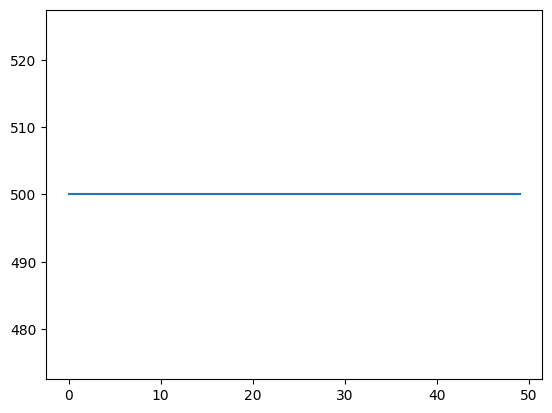


Recompensa de Media: 500.0 



In [81]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

### Construcción de base de datos experta con 7 trayectoria 

In [82]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [83]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

3500


In [84]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [85]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [86]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2800
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 700


In [87]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [88]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [89]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [90]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.2627785

g_loss= -1.2081658
 1/32 [..............................] - ETA: 3:43:30 - d_loss: 2.2628 - g_loss: -1.2082


d_loss= 2.245974

g_loss= -0.40965778
 2/32 [>.............................] - ETA: 3:36:05 - d_loss: 2.2544 - g_loss: -0.8089


d_loss= 2.2837458

g_loss= -1.6632388
 3/32 [=>............................] - ETA: 3:28:59 - d_loss: 2.2642 - g_loss: -1.0937


d_loss= 2.268205

g_loss= -1.4190702
 4/32 [==>...........................] - ETA: 3:23:08 - d_loss: 2.2652 - g_loss: -1.1750


d_loss= 2.2479057

g_loss= -0.88088745
 5/32 [===>..........................] - ETA: 3:14:55 - d_loss: 2.2617 - g_loss: -1.1162


d_loss= 2.2348933

g_loss= -1.2928873
 6/32 [====>.........................] - ETA: 3:07:25 - d_loss: 2.2573 - g_loss: -1.1457


d_loss= 2.2288628

g_loss= -1.367751
 7/32 [=====>........................] - ETA: 3:00:17 - d_loss: 2.2532 - g_loss: -1.1774


d_loss= 2.245161

g_loss= -0.9371078
 8/32 [======>.......................] - ETA: 2:53:42 - d_

### Evaluación de GAIL

In [91]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.3447 - accuracy: 0.0000e+00
>Loss real: 
0.29089611768722534
>Loss fake: 
0.3447364866733551


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

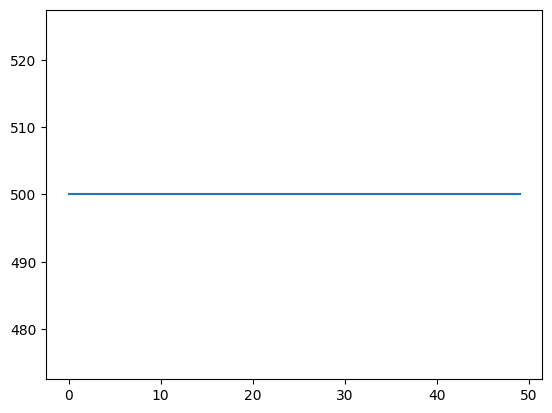


Recompensa de Media: 500.0 



In [92]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

### Construcción de base de datos experta con 8 trayectoria 

In [93]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [94]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

4000


In [95]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [96]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [97]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3200
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 800


In [98]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [99]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [100]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [101]:



d_loss= 1.9028171# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.1697774

g_loss= -1.5597289
 1/36 [..............................] - ETA: 4:10:34 - d_loss: 2.1698 - g_loss: -1.5597


d_loss= 2.1399043

g_loss= -0.35017142
 2/36 [>.............................] - ETA: 4:06:15 - d_loss: 2.1548 - g_loss: -0.9550


d_loss= 2.1626096

g_loss= -1.0183012
 3/36 [=>............................] - ETA: 3:58:29 - d_loss: 2.1574 - g_loss: -0.9761


d_loss= 2.2157388

g_loss= -0.73820883
 4/36 [==>...........................] - ETA: 3:52:57 - d_loss: 2.1720 - g_loss: -0.9166


d_loss= 2.1666217

g_loss= -1.483122
 5/36 [===>..........................] - ETA: 3:44:42 - d_loss: 2.1709 - g_loss: -1.0299


d_loss= 2.1323433

g_loss= -0.5879846
 6/36 [====>.........................] - ETA: 3:36:37 - d_loss: 2.1645 - g_loss: -0.9563


d_loss= 2.1971912

g_loss= -0.7611923
 7/36 [====>.........................] - ETA: 3:29:12 - d_loss: 2.1692 - g_loss: -0.9284


d_loss= 2.173633

g_loss= -0.5420405
 8/36 [=====>........................] - ETA: 3:22:00 - 

### Evaluación de GAIL

In [102]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.2767 - accuracy: 0.0000e+00
>Loss real: 
0.19435139000415802
>Loss fake: 
0.276705265045166


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

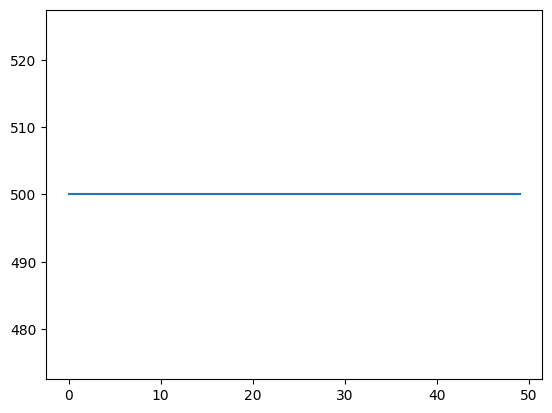


Recompensa de Media: 500.0 



In [103]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

### Construcción de base de datos experta con 9 trayectoria 

In [104]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [105]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

4500


In [106]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [107]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [108]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3600
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 900


In [109]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [110]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [111]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [112]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.101496

g_loss= -1.5698965
 1/40 [..............................] - ETA: 4:40:48 - d_loss: 2.1015 - g_loss: -1.5699


d_loss= 2.0969992

g_loss= -1.5865163
 2/40 [>.............................] - ETA: 4:31:32 - d_loss: 2.0992 - g_loss: -1.5782


d_loss= 2.104494

g_loss= -0.40111595
 3/40 [=>............................] - ETA: 4:25:11 - d_loss: 2.1010 - g_loss: -1.1858


d_loss= 2.0349522

g_loss= -0.3887611
 4/40 [==>...........................] - ETA: 4:18:39 - d_loss: 2.0845 - g_loss: -0.9866


d_loss= 2.0286617

g_loss= -0.46036655
 5/40 [==>...........................] - ETA: 4:11:23 - d_loss: 2.0733 - g_loss: -0.8813


d_loss= 2.090818

g_loss= -0.46212015
 6/40 [===>..........................] - ETA: 4:05:35 - d_loss: 2.0762 - g_loss: -0.8115


d_loss= 2.1079206

g_loss= -0.84285665
 7/40 [====>.........................] - ETA: 3:58:06 - d_loss: 2.0808 - g_loss: -0.8159


d_loss= 2.0476854

g_loss= -1.0931921
 8/40 [=====>........................] - ETA: 3:51:50 -

### Evaluación de GAIL

In [113]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.1083 - accuracy: 0.0000e+00
>Loss real: 
0.1109808161854744
>Loss fake: 
0.10825882852077484


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

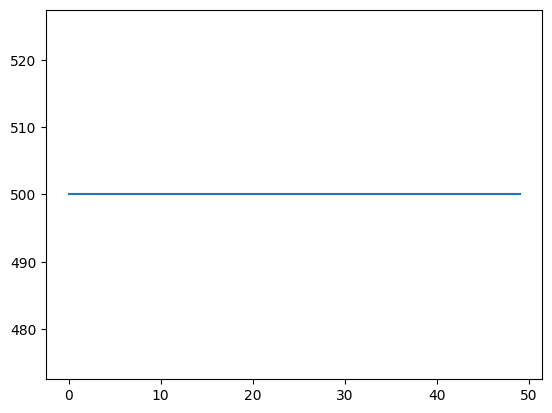


Recompensa de Media: 500.0 



In [114]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

### Construcción de base de datos experta con 10 trayectoria 

In [116]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_CartPole_.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]

	 Estados siguientes: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]

	 Recompensas: [1 1 1 ... 1 1 1]


In [117]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

5000


In [118]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [119]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [120]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4000
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1000


In [121]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [122]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [123]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [124]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.9897084

g_loss= -0.4210099
 1/45 [..............................] - ETA: 5:41:15 - d_loss: 1.9897 - g_loss: -0.4210


d_loss= 2.0296123

g_loss= -1.571722
 2/45 [>.............................] - ETA: 5:32:48 - d_loss: 2.0097 - g_loss: -0.9964


d_loss= 1.9736164

g_loss= -1.0454295
 3/45 [=>............................] - ETA: 5:26:33 - d_loss: 1.9976 - g_loss: -1.0127


d_loss= 2.0160303

g_loss= -0.5066986
 4/45 [=>............................] - ETA: 5:17:00 - d_loss: 2.0022 - g_loss: -0.8862


d_loss= 1.936535

g_loss= -0.6647836
 5/45 [==>...........................] - ETA: 5:08:06 - d_loss: 1.9891 - g_loss: -0.8419


d_loss= 2.011438

g_loss= -1.5812024
 6/45 [===>..........................] - ETA: 5:00:16 - d_loss: 1.9928 - g_loss: -0.9651


d_loss= 2.010145

g_loss= -0.56545055
 7/45 [===>..........................] - ETA: 4:51:48 - d_loss: 1.9953 - g_loss: -0.9080


d_loss= 2.0258663

g_loss= -1.6217943
 8/45 [====>.........................] - ETA: 4:43:52 - d_l

### Evaluación de GAIL

In [125]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.0541 - accuracy: 0.0000e+00
>Loss real: 
0.051025740802288055
>Loss fake: 
0.05410065874457359


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

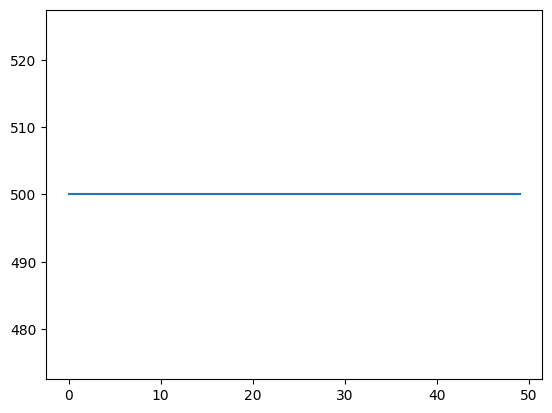


Recompensa de Media: 500.0 



In [126]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')